In [2]:
from __future__ import division
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

# Introduction

In Environmental Economics, you often want to find the socially optimal method of abatement. Abatement is this context means to reduce production of dirty industries. You don't want to hinder the economy by abating dirty industries too much and at the same time you don't want to let those industries run free and pollute the environment too much either. You want to find the socially optimal level of pollution, the level of pollution that society is willing to live with given that they still want to benefit from the positives of dirty industries.

In this lab we are going to model this dual-problem by looking at a simplified example of the Geneva Steel Mill in Utah. To communicate the model choices we will describe the scenario and then describe the variables below.

# Problem 1

**The Scenario**

Assume that most of the people in Orem, Utah work at the steel mill. Because of this, it is imperative that the steel mill stays running for the sake of the community.

Unfortunately, the steel mill releases pollutants in the atmosphere. Residents of Orem, especially children and the elderly, are susceptible to respiratory diseases and death from the pollution produced by the steel mill.

The well-being of residents in Orem depends on the production level of the steel mill and the reduction of air pollution.

Assume that technology, the percentage of people working at the steel mill, population, death rate, and the ability to cure respiratory diseases holds constant. Find the optimal tax rate r(t). Also assume that the steel mill only employs people living in Orem and not from anywhere else.

Find the tax rate function given that the ending time period is 36 months and plot your results. Plot each of your state equations.

**Functions:**

*State Equations:*

x1(t): The level of pollution emmitted from the steel mill.

x2(t): The number cases of respiratory disease.

x3(t): The total production of the steel mill.

*Control Equations:*

r(t): A function representing the tax rate strategy. This does not have to be a constant function.

**Constants:**

tau: The effectiveness level of technology to reduce pollution.

P: The level of population in the valley.

delta: The percentage of the population vulnerable to incoming diseases.

w: The percetage of the population working at the steel mill.

m: The ability to cure respiratory diseases.

gamma: The percentage of pollution that leaves the environment through natural processes.

alpha: How much society values preventing respiratory diseases vs. how much they value money.

**State Evolution Equations:**

$$x_1' = \tau x_3(t) - \gamma x_1(t)$$

$$x_2' = \frac{x_1(t)}{P \delta} - mx_2(t)$$

$$x_3' = wP(1-r(t))$$

**Functional:**

$$max J[r(t)] = \int\limits_0^T [\alpha x_3(t)(1-r(t)^2) - x_2(t)] dx $$

**Initial Conditions**

$$x_1(0) = pol_0$$

$$x_2(0) = sick_0$$

$$x_3(0) = steel_0$$

##Initializing our constants

In [3]:
#Initial state of pollution or x1(0) = 0
pol_0 = 0
#Initial state of respiratory diseases or x2(0) = 0
sick_0 = 0
#Initial state of production or x3(0) = 0
steel_0 = 0

#Params
tau = 1.
gamma = .2
delta=.30
w = .8
alpha = 50
P = 100
t0 = 0
t_f = 36
n = 36
m = .7

##State Equations

In [4]:
state = np.zeros((n,3))
state0 = np.array([pol_0,sick_0,steel_0])
costate = np.zeros((n,3))
costate0 = np.zeros(3)

r=np.zeros(n) + .02

def state_equations_prob1(t,y,i):
    """
    This function is of the state evolution equations for problem 1.
    """
    x1,x2,x3 = y

    x1_prime = (x3*tau-gamma*x1)
    x2_prime = x1/P*delta - m*x2
    x3_prime = w*P*(1-r[i])#x3 - r[i]*x3
    y_dot = np.array([x1_prime,x2_prime,x3_prime])
    
    return y_dot

##Helper functions to solve ode system

In [5]:
def initialize_all(y0, t0, t, n):
    """ An initialization routine for the different ODE solving
    methods in the lab. This initializes Y, T, and h. """
    if isinstance(y0, np.ndarray):
        Y = np.empty((n, y0.size)).squeeze()
    else:
        Y = np.empty(n)
    Y[0] = y0
    T = np.linspace(t0, t, n)
    h = float(t - t0) / (n - 1)
    return Y, T, h

def RK4(f, y0, t0, t, n):
    """ Use the RK4 method to compute an approximate solution
    to the ODE y✬ = f(t, y) at n equispaced parameter values from t0 to t
    with initial conditions y(t0) = y0.
    y0 is assumed to be either a constant or a one-dimensional numpy array.
    t and t0 are assumed to be constants.
    f is assumed to accept three arguments.
    The first is a constant giving the value of t.
    The second is a one-dimensional numpy array of the same size as y.
    The third is an index to the other arrays.
    This function returns an array Y of shape (n,) if
    y is a constant or an array of size 1.
    It returns an array of shape (n, y.size) otherwise.
    In either case, Y[i] is the approximate value of y at
    the i✬th value of np.linspace(t0, t, n).
    """
    Y,T,h = initialize_all(y0,t0,t,n)
    
    for i in xrange(n-1):
        K1 = f(T[i],Y[i],i)
        K2 = f(T[i]+h/2.,Y[i]+h/2.*K1,i)
        K3 = f(T[i]+h/2.,Y[i]+h/2.*K2,i)
        K4 = f(T[i+1],Y[i]+h*K3,i)
        Y[i+1] = Y[i] + h/6.*(K1+2*K2 +2*K3+K4)
        #print Y[i+1]
    return Y

##Solving Costate Equations

In [6]:
def lambda_hat_prob1(t,lambs,i):
    """
    Parameters
    ---------------
    t : float
    the time
    y : ndarray (2,)
    the lambda_hat values at time t
    i : int
    index for global variables, u and state.
    Returns
    --------------
    y_dot : ndarray (2,)
    the derivative of the lambda_hats at time t.
    """
    lam1,lam2,lam3 = lambs
    x1= state[:,0]
    x2= state[:,1]
    x3= state[:,2]

    lam1_prime = lam1*gamma - lam2/(P*delta)
    lam2_prime = lam2*m - 1
    lam3_prime = -lam1*tau + alpha*(1-r[-i]**2)
    y_dot = np.array([lam1_prime,lam2_prime,lam3_prime])
    
    return y_dot

##Solving the system

In [7]:
def calc_state(state_equations,lambda_hat):
    """
    This function calculates the state equation along with the optimal tax rate.
    
    Inputs:
    
    state_equations - The state evolution equations.
    
    lambda_hat - The costate evolution equations.
    
    Returns:
    
    state - The state equation.
    
    r - A function that determines the tax rate based on time t.
    """
    epsilon = 0.001
    test = epsilon + 1
    r = np.ones(n)*.5
    a = 0.
    b = 1.
    #print test
    while(test > epsilon):

        oldr = r.copy();

        #Updating the state equation
        state = RK4(state_equations,state0,t0,t_f,n)
        x1 = state[:,0]
        x2 = state[:,1]
        x3 = state[:,2]

        #Updating the costate
        costate = RK4(lambda_hat,costate0,t0,t_f,n)[::-1]

        #Updating the values of lam1, lam2, and lam3
        lam1 = costate[:,0]
        lam2 = costate[:,1]
        lam3 = costate[:,2]
        r_star = np.minimum(np.maximum(a, (lam3*w*P)/(2.*alpha*x3)  ),b)

        #Updating r
        r = 0.5*(r_star + oldr)
        
        #test for convergence
        test = abs(oldr - r).sum()
    
    return state,r

In [8]:
def plot_func(state,r):
    """
    This function plots the graphs of our pollution function, production function, 
    respiratory disease function, and our recommended control function.
    """
    fig = plt.figure()
    fig.subplots_adjust(hspace=.5)
    time = np.linspace(0, t_f, n)

    
    plt.subplot(221)
    plt.plot(time, state[:,0])
    plt.title("x1 (Pollution)")
        

    
    plt.subplot(222)
    plt.plot(time, state[:,1])
    plt.title("x2 (Respiratory Diseases)")

    plt.subplot(223)
    plt.plot(time, state[:,2])
    plt.title("x3 (Production)")

    plt.subplot(224)
    plt.plot(time, r)
    plt.xlabel("rate")
    plt.title("Tax Rate")
    
    
    plt.show()

# Executing the Above Functions to plot out state equations and control

C:\Users\kaweie\Anaconda2\lib\site-packages\ipykernel\__main__.py:40: RuntimeWarning: divide by zero encountered in true_divide


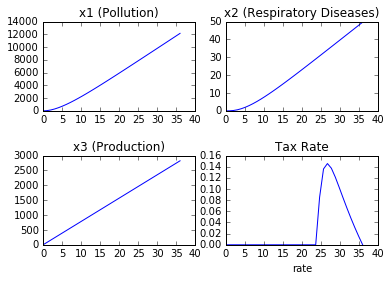

In [9]:
state,r = calc_state(state_equations_prob1,lambda_hat_prob1)
plot_func(state,r)

# Conclusion

We notice that the max tax rate is a round 15% and after it reaches the max, the tax rate then decreases back to zero.

# Problem 2

Winter inversion is a phenomena where air pollution gets trapped in a valley by tall mountains. Instead of the pollution naturally leaving a valley, it sticks around and reduces air quality. For Utah, this phenomena is cyclical; as temperatures decrease, pollution gets worse and as temperatures increase, inversion decreases. 

For problem 2, find the optimal tax rate function r(t) and the state equations, taking into account inversion.

In a simplistic model we change our state evolution equation for x2 to:

$$x_2' = \frac{cos(t)x_1}{P\delta} - mx_2$$


In [10]:
def state_equations_inversion(t,y,i):
    """
    This calculates the state evolution equations that takes account of inversion into our model.
    This is the state evolution equations that we will use for the remainder of this lab.
    This lab is steadily adding more and more layers to our model.
    """
    x1,x2,x3 = y

    x1_prime = x3*tau - gamma*x1*np.cos(t*np.pi/6.)
    x2_prime = x1/P*delta - m*x2
    x3_prime = w*P*(1-r[i])#x3 - r[i]*x3
    y_dot = np.array([x1_prime,x2_prime,x3_prime])
    
    return y_dot
    
    

def lambda_hat_inversion(t,lambs,i):
    """
    Parameters
    ---------------
    t : float
    the time
    y : ndarray (2,)
    the lambda_hat values at time t
    i : int
    index for global variables, r and state.
    Returns
    --------------
    y_dot : ndarray (2,)
    the derivative of the lambda_hats at time t.
    """
    lam1,lam2,lam3 = lambs
    x1= state[:,0]
    x2= state[:,1]
    x3= state[:,2]

    lam1_prime = -lam2/(P*delta)+lam1*gamma*np.cos(t*np.pi/6.)
    lam2_prime = lam2*m - 1
    lam3_prime = -lam1*tau + alpha*(1-r[-i]**2)
    #print lam1*tau, lam3*(1-r[-i]), alpha*(1-r[-i]**2), lam3, r[-i]
    y_dot = np.array([lam1_prime,lam2_prime,lam3_prime])
    
    return y_dot

C:\Users\kaweie\Anaconda2\lib\site-packages\ipykernel\__main__.py:40: RuntimeWarning: divide by zero encountered in true_divide


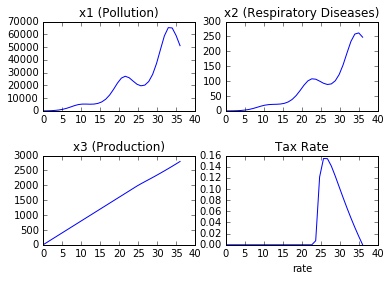

In [11]:
state,r = calc_state(state_equations_inversion,lambda_hat_inversion)
plot_func(state,r)

# Conclusion

The tax rate reaches a maximum of about 15% and follows similarly as problem 1. The difference between the two problems are the functions for of x1 and x2.

# Problem 3

Create three more plots where you change constant parameters and compare the results.

There are three different scenarios. That are required. Complete these three and then come up with one of your own. Compare the results and graphs.

# Scenario 1: Change m = .95

This means that we are increasing the percentage of people cured from respiratory diseases from 75% to 90%.

In [12]:
#Initial state of pollution or x1(0) = 0
pol_0 = 0

#Initial state of respiratory diseases or x2(0) = 0
sick_0 = 0

#Initial state of production or x3(0) = 0
steel_0 = 0

#Parameter representing how good technology is at reducing pollution
tau = 1.

#Parameter representing the removal of pollutants due to nature.
gamma = .2

#Parameter representing the percentage of the population vulnerable to respiratory diseases.
delta=.30

#Parameter representing percentage of the population that works at the steel mill.
w = .8

#Parameter representing society's value of good health instead of money.
alpha = 50

#Population of Orem
P = 100

#Begining Time
t0 = 0

#Ending time, after 36 months
t_f = 36
n = 36

#Parameter representing the percent of people healed from the respiratory diseases.
m = .95

C:\Users\kaweie\Anaconda2\lib\site-packages\ipykernel\__main__.py:40: RuntimeWarning: divide by zero encountered in true_divide


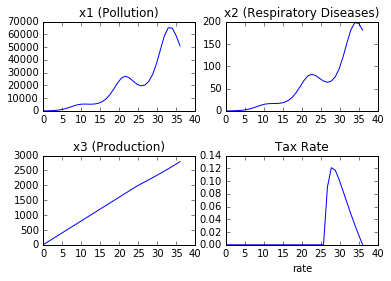

In [13]:
state,r = calc_state(state_equations_inversion,lambda_hat_inversion)
plot_func(state,r)

# Conclusion

If you compare these graphs to the previous problem, the maximum tax rate decreases to 12% compared to the max of 15% before. The reason for this is because the summer months reduce pollution, therefore, the tax doesn't have to be as high since pollution naturally goes down in the summer.

Notice that there is a little bend in the production function, this reflects the effect of the tax rate function at around the 24 month mark.

# Scenario 2 tau = 5:

which is increasing ability of technology to abate pollution.

In [14]:
#Initial state of pollution or x1(0) = 0
pol_0 = 0
#Initial state of respiratory diseases or x2(0) = 0
sick_0 = 0
#Initial state of production or x3(0) = 0
steel_0 = 0
#Parameter representing how good technology is at reducing pollution
tau = 0.25
#Parameter representing the removal of pollutants due to nature.
gamma = .2

#Parameter representing the percentage of the population vulnerable to respiratory diseases.
delta=.30

#Parameter representing percentage of the population that works at the steel mill.
w = .8

#Parameter representing society's value of good health instead of money.
alpha = 50

#Population of Orem
P = 100

#Begining Time
t0 = 0

#Ending time, after 36 months
t_f = 36
n = 36

#Parameter representing the percent of people healed from the respiratory diseases.
m = .95

C:\Users\kaweie\Anaconda2\lib\site-packages\ipykernel\__main__.py:40: RuntimeWarning: divide by zero encountered in true_divide


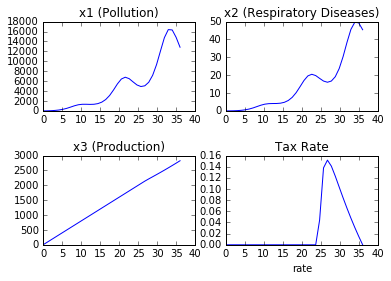

In [15]:
state,r = calc_state(state_equations_inversion,lambda_hat_inversion)
plot_func(state,r)

# Conclusion

We decreased tau to .25, and this greatly increased the amount of pollution and increased the max tax rate to 16%. 

# Scenario 3 alpha = 100:

The greater the value of alpha, the more society values health over economic well-being.

In [16]:
#Initial state of pollution or x1(0) = 0
pol_0 = 0

#Initial state of respiratory diseases or x2(0) = 0
sick_0 = 0

#Initial state of production or x3(0) = 0
steel_0 = 0

#Parameter representing how good technology is at reducing pollution
tau = 0.25

#Parameter representing the removal of pollutants due to nature.
gamma = .2

#Parameter representing the percentage of the population vulnerable to respiratory diseases.
delta=.30

#Parameter representing percentage of the population that works at the steel mill.
w = .8

#Parameter representing society's value of good health instead of money.
alpha = 100.

#Population of Orem
P = 100

#Starting Time
t0 = 0

#Ending time, after 36 months
t_f = 36
n = 36

#Parameter representing the percent of people healed from the respiratory diseases.
m = .95

C:\Users\kaweie\Anaconda2\lib\site-packages\ipykernel\__main__.py:40: RuntimeWarning: divide by zero encountered in true_divide


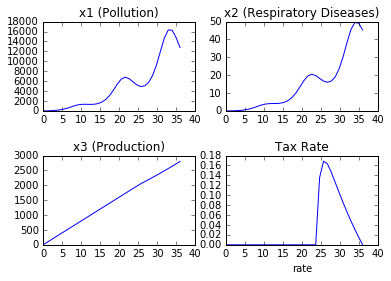

In [17]:
state,r = calc_state(state_equations_inversion,lambda_hat_inversion)
plot_func(state,r)

# Conclusion

With alpha twice as much as the previous situation, it's no wonder that the max tax rate is greater than all of the other max tax rates for previous problems. Orem citizens in this case value clean air more than jobs, and the tax rate reflects that.

# Scenario 4: Set alpha = 50,  m = .02

In [18]:
#Initial state of pollution or x1(0) = 0
pol_0 = 0
#Initial state of respiratory diseases or x2(0) = 0
sick_0 = 0
#Initial state of production or x3(0) = 0
steel_0 = 0
#Parameter representing how good technology is at reducing pollution
tau = 0.25
#Parameter representing the removal of pollutants due to nature.
gamma = .2

#Parameter representing the percentage of the population vulnerable to respiratory diseases.
delta=.30

#Parameter representing percentage of the population that works at the steel mill.
w = .8

#Parameter representing society's value of good health instead of money.
alpha = 50.

#Population of Orem
P = 100

#Starting time.
t0 = 0

#Ending time, after 36 months
t_f = 36
n = 36

#Parameter representing the percent of people healed from the respiratory diseases.
m = .2

C:\Users\kaweie\Anaconda2\lib\site-packages\ipykernel\__main__.py:40: RuntimeWarning: divide by zero encountered in true_divide


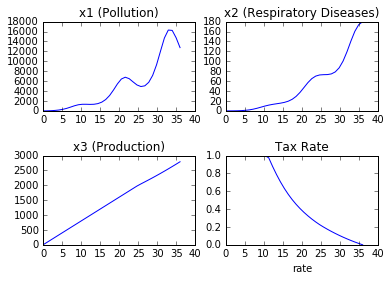

In [19]:
state,r = calc_state(state_equations_inversion,lambda_hat_inversion)
plot_func(state,r)

# Conclusion

From this situation, we see that there should be no production from month 0 to 13 and the from month 2.4 to 21, the tax rate should be 100%.

We inputted this example just to see how ineffectiveness of treating patients can have on the economy.